<a href="https://colab.research.google.com/github/alejomd17/Econometria-Espacial-Indicadores-de-Asociacion-Espacial/blob/main/BI_LISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadísticos Bivariado de Asociación Espacial

En este cuadernillo de Python se ilustra la implementación del estadístico bivariado global de Moran y los estadísticos locales bivariados de Moran o Bi-LISA. El paquete `pysal` contiene las funciones requeridas para implementar estas métricas.

# Preparación

## Instalar y cargar paquetes

In [ ]:
## Instalar Paquetes

# Bibliotequa GDAL (Geospatial Data Abstraction Library)
!apt install gdal-bin python-gdal python3-gdal --quiet
# Instalar rtree - Requerido por Geopandas
!apt install python3-rtree --quiet
# Instalar descartes - Requerido por Geopandas
!pip install descartes --quiet
# Instalar Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet

# Install geovisualization libraries
!pip install folium  --quiet
!pip install plotly_express  --quiet
!pip install mapclassify --


# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

!pip install pytest --quiet
!pip install pytest-cov --quiet

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2

In [ ]:
## Cargar Paquetes

# Procesamiento de datos espaciales
import pandas as pd 
import geopandas as gpd
import fiona
from shapely.geometry import Point

# Funciones matemàticas
import numpy as np

# Producciòn de gràficos y mapas
import matplotlib.pyplot as plt 
%matplotlib inline
import folium
import plotly
import plotly_express as px
import seaborn as sns

# AEDE
from libpysal.weights import Queen, attach_islands, KNN
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.explore import esda
from pysal.lib import weights
import pysal as ps

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Montar Drive

In [ ]:
## Montar Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Classroom/Datos"

'icv ant.csv'   ipm_rural_2018.csv   nbi.csv   pob.csv	 va_col_2016_2.csv


## Cargar datos

En este ejercicio se ilustrará el cálculo del estadístico bivariado de Moran global y local usando información para los municipios colombianos acerca de la proporción de población multidimensionalmente pobre ([la incidencia del IPM estimada por el DANE](https://www.dane.gov.co/files/CensoAgropecuario/entrega-definitiva/Boletin-4-Pobreza-y-educacion/4-Anexos-municipales.xls)) y el valor agregado de 2016 ([también estimado por el DANE](https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/cuentas-nacionales-departamentales/indicador-de-importancia-economica-municipal)).

Por tanto, a continuación se leen los archivos de datos correspondientes a el *shape* municipal de Colombia, la incidencia de la pobreza rural según el índice de pobreza multidimensional de 2018, el valor agregado municipal de 2016, y las proyecciones poblacionales del DANE, con el fin de calcular el valor agregado per cáptia del año 2016.

In [ ]:
# Cargar shape municipal de Colombia
shp = gpd.read_file("/content/drive/My Drive/Classroom/Datos Geográficos/Shp Col Mun/colMun.shp")
shp.sample(3)

,OBJECTID,codigo,AREA_OFICI,ENTIDAD_TE,NOM_DEPART,NOM_MUNICI,COD_DEPTO,SHAPE_area,SHAPE_len,DIVIPOLA,geometry
525,526,27745,1274.0,Cabecera Municipal,CHOCÓ,SIPÍ,27,1.578497e+09,231157.176806,27745,"POLYGON ((730178.667 1022600.911, 730276.258 1..."
1042,1048,73555,1445.0,Cabecera Municipal,TOLIMA,PLANADAS,73,1.751854e+09,221475.057156,73555,"POLYGON ((782976.191 817134.414, 782957.359 81..."
456,457,52083,48.0,Cabecera Municipal,NARIÑO,BELÉN,52,4.263104e+07,39933.950877,52083,"POLYGON ((667774.811 663952.618, 667667.511 66..."


In [ ]:
# Leer incidencia de la pobreza multidimensional rural municipal en 2018
ipm = pd.read_csv('/content/drive/My Drive/Classroom/Datos/ipm_rural_2018.csv', sep=';',encoding='latin-1')
ipm.sample(5)

,codigo,nom_mun,ipm_incidencia
745,52385,La Llanada,20.5
68,5440,Marinilla,22.5
299,15778,Sutatenza,46.5
294,15762,Sora,26.0
198,15051,Arcabuco,40.3


In [ ]:
# Leer valor agregado municipal de 2016
va = pd.read_csv('/content/drive/My Drive/Classroom/Datos/va_col_2016_2.csv', sep=';',encoding='latin-1')
va.sample(5)

,CodDep,Codigo,Departamento,Municipio,grado,Valor_agregado,Peso_relativo
1026,76,76364,Valle Del Cauca,Jamundí,2,1557,2.2
980,73,73352,Tolima,Icononzo,6,95,0.5
126,8,8078,Atlántico,Baranoa,3,692,2.0
1057,85,85125,Casanare,Hato Corozal,5,269,2.4
475,25,25181,Cundinamarca,Choachí,6,132,0.3


In [ ]:
# Cargar proyecciones de población del DANE
pob = pd.read_csv('/content/drive/My Drive/Classroom/Datos/pob.csv', sep=',',encoding='latin-1')
pob.sample(5)

,depto,codigo,mpio,a1985,a1986,a1987,a1988,a1989,a1990,a1991,a1992,a1993,a1994,a1995,a1996,a1997,a1998,a1999,a2000,a2001,a2002,a2003,a2004,a2005,a2006,a2007,a2008,a2009,a2010,a2011,a2012,a2013,a2014,a2015,a2016,a2017,a2018,a2019,a2020
1018,Valle del Cauca,76233,Dagua,31469,31744,32007,32273,32542,32789,33036,33274,33485,33695,33884,34065,34227,34371,34503,34624,34744,34858,34983,35123,35270,35395,35507,35614,35713,35817,35931,36046,36159,36282,36406,36524,36652,36775,36891,37005
573,Cundinamarca,25899,Zipaquirá,60202,62160,64059,65920,67764,69616,71415,73259,75166,77152,79239,81516,83824,86134,88416,90650,92860,95043,97210,99373,101562,103721,105830,107918,110003,112069,114161,116215,118267,120312,122347,124376,126409,128426,130432,132419
101,Antioquia,5686,Santa Rosa de Osos,25537,25465,25406,25370,25362,25385,25451,25563,25725,25943,26213,26536,26906,27322,27780,28280,28816,29366,29921,30477,31025,31560,32013,32469,32923,33380,33838,34295,34753,35202,35650,36103,36548,36991,37435,37864
453,Córdoba,23682,San José de Uré(1),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10032,10133,10245,10376,10514,10664,10823,10993,11172,11357,11549,11742,11934
42,Antioquia,5237,Don Matías,11806,12068,12334,12602,12870,13140,13411,13680,13946,14208,14469,14733,15002,15278,15567,15870,16195,16537,16900,17287,17701,18138,18580,19014,19458,19908,20371,20828,21295,21768,22243,22726,23209,23709,24201,24695


## Gestión de datos

A continuación se renombran algunas columnas y se hace el cruce de las distintas fuentes de información.

In [ ]:
# Cambie nombres de variables en DataFrame <<va>>
va.rename(columns={'Codigo': "codigo", 'Valor_agregado': "va2016"}, inplace=True)
va.columns.values

array(['CodDep', 'codigo', 'Departamento ', 'Municipio', 'grado',
       'va2016', 'Peso_relativo'], dtype=object)

In [ ]:
## Modificar algunos nombres de columna en el DataFrame <<pob>> con una expresión regular
# La función <<regex.sub>> del módulo regex permite sustiuir caracteres en una variable
# <string> o cadena de caracteres por medio de expresiones regulares.
# La función <<.rename()>> ejecuta la reasingación de los nombres de variables
# según lo dictado por la función <<regex.sub>>. Como la función <<regex.sub>> 
# solo puede procesar un elemento a la vez, para que esta itere a través de todos 
# los nombres de columna se crea una función anónima (o sin nombre) a través de
# del comando o palabra clave <<lambda>>.
import regex 
pob = pob.rename(columns=lambda x: regex.sub(r'[a]{1}([0-9]{4})',r'pob\1',x))
pob.head()

,depto,codigo,mpio,pob1985,pob1986,pob1987,pob1988,pob1989,pob1990,pob1991,pob1992,pob1993,pob1994,pob1995,pob1996,pob1997,pob1998,pob1999,pob2000,pob2001,pob2002,pob2003,pob2004,pob2005,pob2006,pob2007,pob2008,pob2009,pob2010,pob2011,pob2012,pob2013,pob2014,pob2015,pob2016,pob2017,pob2018,pob2019,pob2020
0,Antioquia,5001,Medellín,1535955,1565394,1595095,1625321,1656333,1688394,1721767,1756711,1793491,1832197,1872241,1912860,1953293,1992781,2030560,2065871,2098618,2129874,2159609,2187831,2214494,2239003,2265244,2291378,2317336,2343049,2368282,2393011,2417325,2441123,2464322,2486723,2508452,2529403,2549537,2569007
1,Antioquia,5002,Abejorral,26049,25813,25575,25331,25071,24789,24479,24129,23735,23297,22875,22479,22109,21768,21462,21195,20966,20759,20570,20401,20249,20113,20022,19930,19853,19750,19672,19570,19478,19382,19290,19195,19096,18991,18882,18779
2,Antioquia,5004,Abriaquí,3067,3098,3127,3156,3179,3201,3214,3222,3220,3209,3187,3158,3121,3076,3027,2971,2912,2856,2799,2744,2690,2636,2570,2504,2458,2397,2336,2290,2231,2175,2128,2075,2019,1971,1918,1870
3,Antioquia,5021,Alejandría,4909,4903,4895,4886,4872,4851,4823,4784,4732,4666,4589,4503,4412,4319,4226,4137,4053,3978,3912,3858,3816,3789,3747,3724,3688,3652,3618,3575,3550,3502,3466,3435,3393,3361,3307,3278
4,Antioquia,5030,Amagá,21984,22313,22644,22974,23296,23606,23901,24173,24419,24633,24823,25002,25175,25356,25553,25775,26027,26294,26571,26858,27155,27455,27709,27950,28192,28433,28664,28897,29117,29339,29555,29770,29980,30181,30376,30561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,Vaupés,97889,Yavaraté (ANM),1024,1055,1093,1130,1171,1212,1257,1300,1349,1348,1346,1345,1341,1335,1327,1315,1303,1291,1281,1273,1269,1268,1266,1264,1261,1258,1255,1251,1248,1244,1240,1235,1231,1226,1222,1218
1118,Vichada,99001,Puerto Carreño,9695,10083,10494,10920,11357,11801,12266,12730,13203,13220,13194,13165,13115,13057,13006,12977,12972,12985,13031,13127,13288,13535,13783,14030,14276,14522,14767,15012,15258,15505,15753,16000,16249,16504,16763,17031
1119,Vichada,99524,La Primavera,4614,4776,4950,5133,5311,5508,5705,5914,6124,6552,6960,7363,7749,8119,8478,8832,9176,9521,9870,10232,10616,11034,11464,11906,12359,12825,13301,13791,14294,14810,15342,15886,16447,17026,17626,18248
1120,Vichada,99624,Santa Rosalía,1536,1591,1646,1709,1769,1837,1903,1974,2044,2086,2171,2286,2419,2558,2693,2810,2905,2997,3084,3168,3250,3336,3420,3502,3581,3659,3734,3807,3877,3946,4012,4076,4138,4197,4255,4310


Chequea que las variables de enlace o llave para cruzar las distintas fuentes de información sean del mismo tipo. Si este no es el caso es necesario forzar las variables enlace al mismo tipo.

In [ ]:
# Chequee tipos de variables

print('\n',shp.codigo.dtypes)
print('\n',ipm.codigo.dtypes)
print('\n',va.codigo.dtypes)
print('\n',pob.codigo.dtypes)


 object

 int64

 int64

 int64


In [ ]:
# Transforme como variable <<integer>> la variable código en el GeoDataFrame <<shp>>
shp.codigo = shp.codigo.astype('int')

Después de las anteriores precauciones, se puede proceder a cruzar las fuentes de información

In [ ]:
# Cruce de datos
col = shp.merge(va[['codigo','va2016']],on='codigo',how='outer')
col = col.merge(pob[['codigo','pob2016']],on='codigo',how='outer')
col = col.merge(ipm,on='codigo',how='inner')
col.columns.values # Inspeccione nombres de columna en la base de datos resultante

array(['OBJECTID', 'codigo', 'AREA_OFICI', 'ENTIDAD_TE', 'NOM_DEPART',
       'NOM_MUNICI', 'COD_DEPTO', 'SHAPE_area', 'SHAPE_len', 'DIVIPOLA',
       'geometry', 'va2016', 'pob2016', 'nom_mun', 'ipm_incidencia'],
      dtype=object)

In [ ]:
#  Calcule valor agregegado per cápita en 2016.
# El valor agregado está en millones de pesos. Deshacemos esta estandarización
col['vapc2016'] = 1e6*col.va2016/col.pob2016

#  Calcule el logaritmo natural del valor agregado per cápita en 2016 
col['lnvapc2016'] = np.log(1+col['vapc2016'])

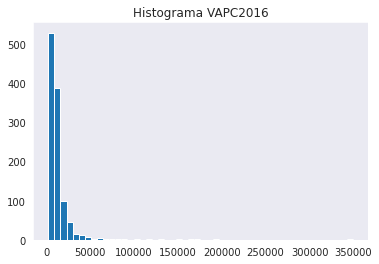

In [ ]:
# Histograma del valor agregado per cápita
with sns.axes_style('dark'):
 plt.hist(col.vapc2016,bins=50)
 plt.title('Histograma VAPC2016')

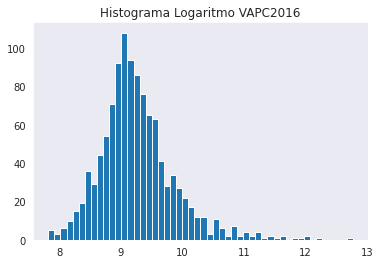

In [ ]:
#  Histograma del logaritmo en base <e> del valor agregado per cápita de 2016.
# Note la manera en la cual cambia la distribución del valor agregado al tomar la
# transformación logarítmica, si se le compara con el histograma precedente.
with sns.axes_style('dark'):
 plt.hist(col.lnvapc2016,bins=50)
 plt.title('Histograma Logaritmo VAPC2016')

Para facilitar la gestión de los pesos espaciales o listados de vecindades, que se generan con gase en el shape municipal, se inspecciona y reasignan los índices o nombres de fila. En particular, se asigna la variable `codigo` como índice.

In [ ]:
col.index # Inspeccione el índice o identificador interno de fila

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121],
           dtype='int64', length=1122)

In [ ]:
# Se va a establecer la variable código como índice
col.sort_values('codigo',ascending=True,inplace=True) # Ordene de manera ascendente
col.set_index('codigo',drop=False,inplace=True) # Establezca una variable de 
              # de los datos como el índice, pero consérvela como una columna.
col.index # Inspeccione el índice

Int64Index([ 5001,  5002,  5004,  5021,  5030,  5031,  5034,  5036,  5038,
             5040,
            ...
            97001, 97161, 97511, 97666, 97777, 97889, 99001, 99524, 99624,
            99773],
           dtype='int64', name='codigo', length=1122)

# AEDE

## Generar lista de vecindades y pesos espaciales

In [ ]:
# Obtenga vecindades por contigüidad tipo reina
wq = Queen.from_dataframe(col,idVariable='codigo') # Genere vecindades tipo Reina
print('Matriz W',wq)
print('\nproporción enlaces no nulos', "%.3f"%wq.pct_nonzero,'\n')


Matriz W <libpysal.weights.contiguity.Queen object at 0x7fa65ae83518>

proporción enlaces no nulos 0.519 



/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 88001, 88564.



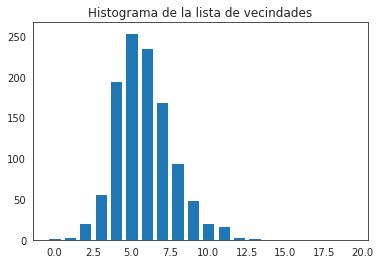

In [ ]:
# Histograma del número de conexiones 
with sns.axes_style('white'):
 hist = np.array(wq.histogram,ndmin=2)
 plt.bar(hist[:,0],hist[:,1])
 plt.title('Histograma de la lista de vecindades')

In [ ]:
# Añadir islas
w_knn1 = KNN.from_dataframe(col,k=1) # K vecindades más cercanas a vuelo de pájaro
wqs = attach_islands(wq,w_knn1) # Añada las islas a las vecindades tipo reina 
wqs.transform = 'r' # Genere pesos espaciales estandarizados por fila

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 280 disconnected components.

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



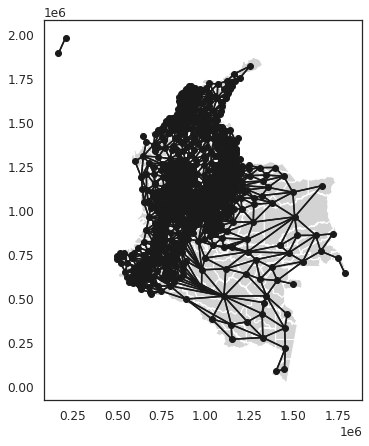

In [ ]:
# Note que ahora no hay islas:
wqs.islands
fig, ax = plt.subplots(figsize=(7,7))
shp.plot(color='lightgrey', ax=ax)
wqs.plot(col, ax=ax) # color='firebrickred', node_kws=dict(marker='*', color='k'), indexed_on='codigo'
plt.show()

## Mapas coropletos

Antes de calcular los estadísticos global y locales de Moran, conviene observar y analizar la distribución espacial de la incidencia de la pobreza multidimensional rural (o proporción de población pobre en la zona rural según el IPM) y la distribución espacial del valor agregado per cápita. 

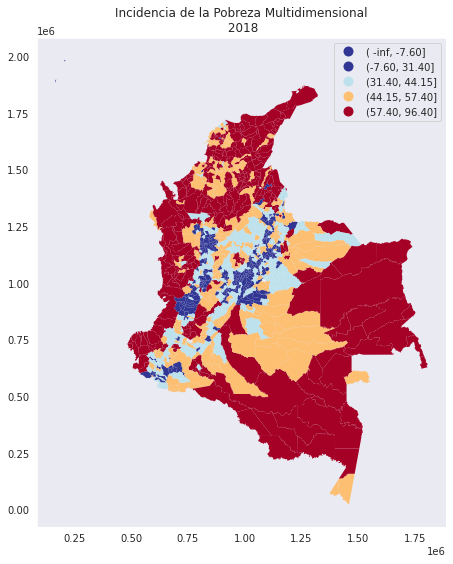

In [ ]:
with sns.axes_style('dark'):
 col.plot(column='ipm_incidencia',cmap='RdYlBu_r',scheme='BoxPlot',
          legend=True, edgecolor='None',figsize=(9,9))
 plt.title('Incidencia de la Pobreza Multidimensional\n 2018')

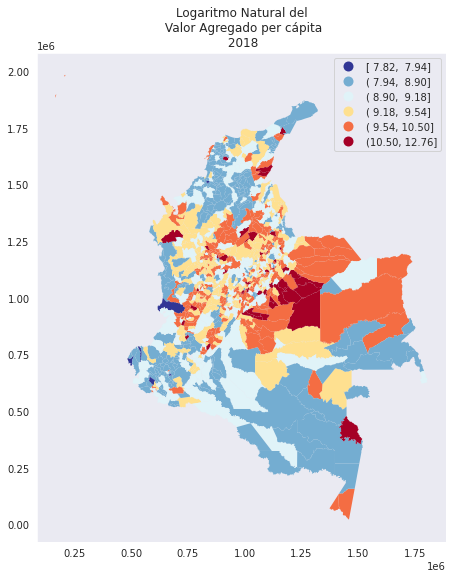

In [ ]:
with sns.axes_style('dark'):
 col.plot(column='lnvapc2016',cmap='RdYlBu_r',scheme='BoxPlot',
          legend=True, edgecolor='None',figsize=(9,9))
 plt.title('Logaritmo Natural del\n Valor Agregado per cápita\n 2018')

## Estadístico univariados globales de Moran                                                        

Se calcula el estadístico univariado de Moran para la incidencia de la pobreza multidimiensionarl y el logaritmo del valor agregado per cápita municipal. Ambas variables presentan dependencia espacial positiva y significativa.

In [ ]:
# Estadístico de Moran
mi_ipm = Moran(col.ipm_incidencia.fillna(100),wqs, permutations=10000)
print('Incidencia IPM 2018 - Ìndice de Moran :',round(mi_ipm.I, 3), '\n p-valor: ',round(mi_ipm.p_sim,5))

mi_va = Moran(col.lnvapc2016.fillna(100),wqs, permutations=10000)
print('log VA pc 2016 - Ìndice de Moran :',round(mi_va.I, 3), '\n p-valor: ',round(mi_va.p_sim,5))


Incidencia IPM 2018 - Ìndice de Moran : 0.683 
 p-valor:  0.0001
log VA pc 2016 - Ìndice de Moran : 0.403 
 p-valor:  0.0001


## LISAs univariados

Se calculan los estadísticos univariados locales de moran para la incidencia de la pobreza multidimiensional y el logaritmo del valor agregado per cáptia municipal, así como los respectivos mapas de clusters.

In [ ]:
moran_loc_ipm = Moran_Local(col.ipm_incidencia, wqs)
moran_loc_va = Moran_Local(col.lnvapc2016, wqs)

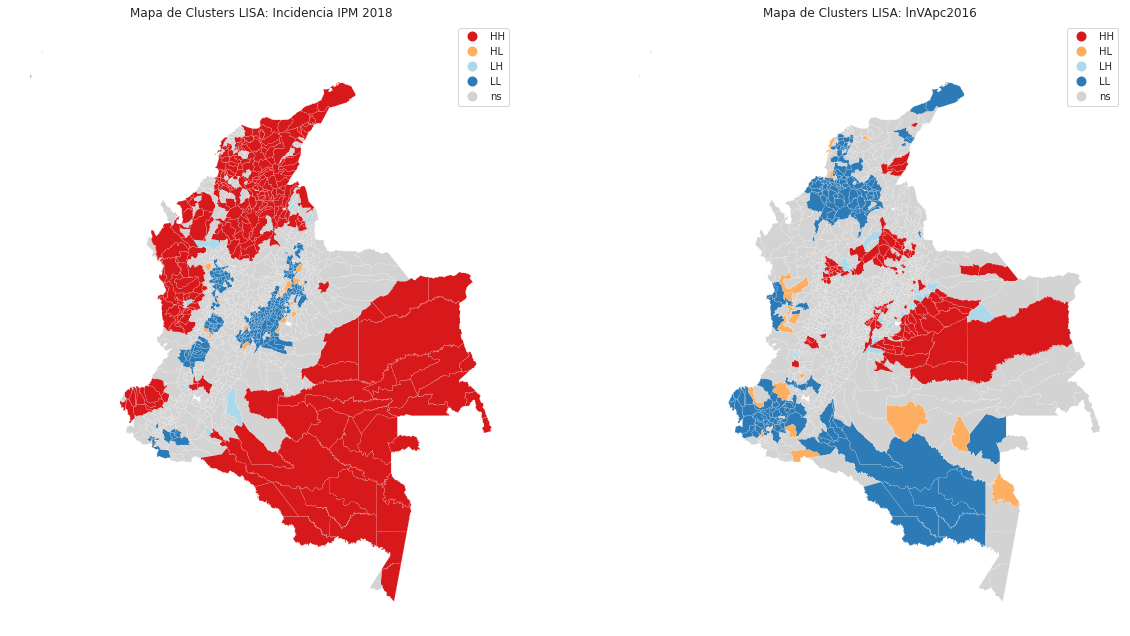

In [ ]:
with sns.axes_style("white"):
 plt.figure(figsize=(20,20)) # Define tamaño de figura en pulgadas
 axes = plt.subplot(1,2,1) # Añade sub-gráfico a figura principal
 lisa_cluster(moran_loc_ipm, col, p=0.05, figsize=(10,10),ax=axes)
 axes.set_title('Mapa de Clusters LISA: Incidencia IPM 2018')

 axes = plt.subplot(1,2,2) # Añade sub-gráfico a figura principal
 lisa_cluster(moran_loc_va, col, p=0.05, figsize=(10,10),ax=axes)
 axes.set_title('Mapa de Clusters LISA: lnVApc2016')

plt.show()


## Estadístico Bivariado Global de Moran

Después de analizar la distribución espacial de ambas variables, a continuación calcula el estadístico bivariado de Moran. Esto se hace a través de la función `Moran_BV`. Es necesario tener en cuenta que la primera variable que se provee como argumento a dicha función es la que se rezaga espacialmente. Esto es importante tenerlo presente a la hora de interprertar el estadístico bivariado de Moran.

Se obtiene que el estadístico bivariado Moran es negativo y significativo. Esto significa, en este caso, que en general los municipios con bajo valor agregado per cápita usualmente tienen vecinos con alta incidencia de la pobreza multidimensional rural o, equivalmentente, que los municipios con alto valor agregado per cápita tienen vecinos con un baja incidencia de la pobreza multidimiensional rural. 

In [ ]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [ ]:
moran_bv = Moran_BV(col.lnvapc2016, col.ipm_incidencia, wqs)
print('Índice de Moran : Rezago Espacial Incidencia IPM 2018 vs. lnVApc2016',round(moran_bv.I, 3), '\n p-valor: ',round(moran_bv.p_sim,5))

Índice de Moran : Rezago Espacial Incidencia IPM 2018 vs. lnVApc2016 -0.293 
 p-valor:  0.001


/usr/local/lib/python3.6/dist-packages/splot/_viz_esda_mpl.py:140: UserWarning:

`p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects



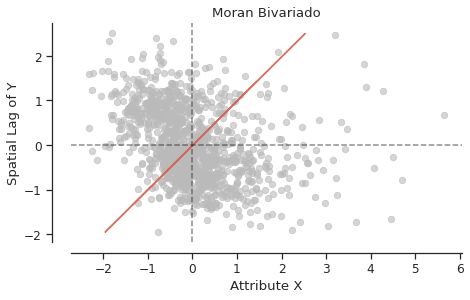

In [ ]:
# Diagrama de dispersión de Moran
with sns.axes_style("white"):
 moran_scatterplot(moran_bv, p=0.05)
 plt.title("Moran Bivariado")
 #plt.savefig('ml_scatter.png') 
 plt.show()

 # Hay un bug en la función del paquete <<pysal>> para generar el diagrama de dispersión de Moran

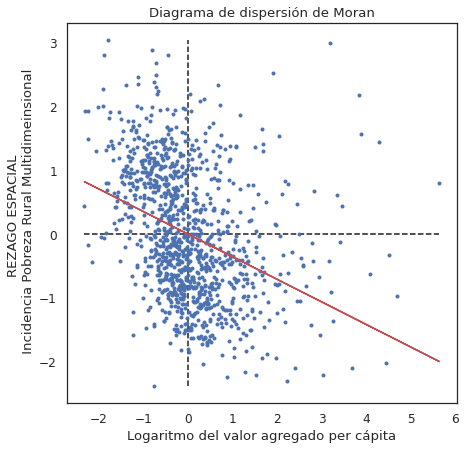

In [ ]:
# Rezago espacial
col['ipm_incidencia_lag'] = weights.lag_spatial(wqs, col.ipm_incidencia)

from sklearn import preprocessing
x, y = preprocessing.scale(col.lnvapc2016), preprocessing.scale(col.ipm_incidencia_lag)

# Diagrama de dispersión de Moran bivariado
sns.set(style='white', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})

b, a = np.polyfit(x, y, 1)

plt.plot(x, y, '.')

# dashed vert at mean of the price
plt.vlines(x.mean(), 
           y.min(), y.max(),
           linestyle='--')
# dashed horizontal at mean of lagged price
plt.hlines(y.mean(), 
           x.min(),x.max(), 
           linestyle='--')

# red line of best fit using global I as slope
plt.plot(x, a + b*x, 'r')
plt.title('Diagrama de dispersión de Moran')
plt.ylabel('REZAGO ESPACIAL \n Incidencia Pobreza Rural Multidimeinsional')
plt.xlabel('Logaritmo del valor agregado per cápita')
plt.show()

## LISAs bivariados

Se calculan los estadísticos bivariados de moran para el *rezago espacial de la incidiencia de la pobreza rural multidimiensional* y el *logartimo del valor agregado per cápita* municipal, a través de la función `Moran_Local_BV`. Con la función `lisa_cluster` se genera el respectivo mapa de clusters.

El mapa de clusters resultante muestra que los agrupamientos más comunes son 1) el HL (Bajo-Alto) y 2) el LH (Alto-Bajo), situación totalmente coherente con el valor negativo obtenido para el estadístico global de Moran bivariado. Esto significa que los vecindarios más comunes son aquellos donde se tienen municipios 1) con bajo valor agregado per cápita cuyos vecinos tienen alta incidencia de la pobreza rural 2) con alto valor agregado per cápita cuyos vecinos tienen baja incidencia de la pobreza rural.

Sin embargo, aparecen algunos agrupamientos que escapan a la tendencia general de autocorrelación espacial negativa (HH y LL), aunque comparativamente son minoritarios. En el agrupamiento HH (Alto-Alto) se tendrían municipios con alto valor agregado per cápita cuyos vecinos tienen alta incidencia de la pobreza multidimiensional rural. En el LL (Bajo-Bajo) se tendría la situación opuesta.

In [ ]:
moran_loc_bv = Moran_Local_BV(col.lnvapc2016, col.ipm_incidencia, wqs)

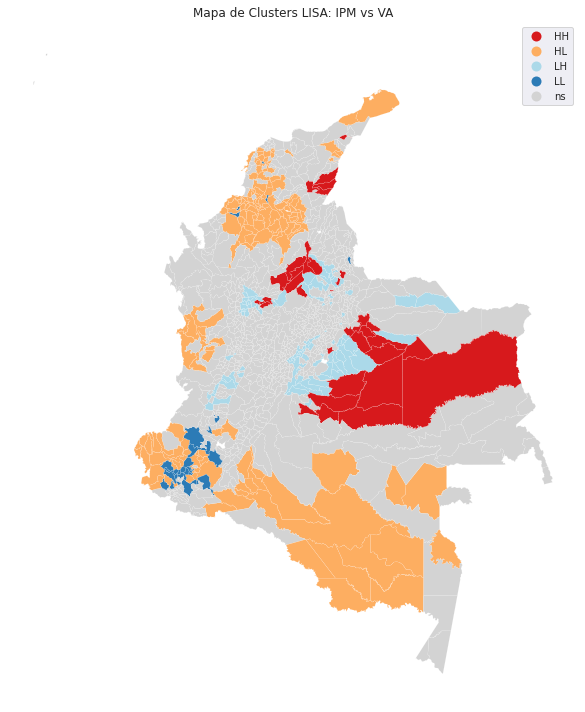

In [ ]:
with sns.axes_style("dark"):
 lisa_cluster(moran_loc_bv, col, p=0.05, figsize=(10,10))
 plt.title('Mapa de Clusters LISA: IPM vs VA')
 plt.tight_layout()
 #plt.savefig('lisa_clusters.png')
 plt.show()

# Referencias

http://pysal.org/notebooks/viz/splot/esda_morans_viz.html